In [32]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import mean_absolute_error, mean_squared_error,\
    confusion_matrix, plot_confusion_matrix, classification_report,\
    accuracy_score, plot_roc_curve

from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer, LabelEncoder

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn import set_config

from sklearn import decomposition

from xgboost import XGBRegressor
from xgboost import XGBClassifier

from sklearn.decomposition import PCA


# IMPORT

In [12]:
df = pd.read_csv('Output_Data\subset_300k_baseline.csv')
df.head()

,log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,...,i_dtype,e_ch,e_m,e_po,e_pl,e_rn,e_section,label_y,cillabel,pro
0,758591,0,152172,3,2,46,138,2,24,2,...,11,19,1217,4,1116,2,0,-1,-1,0
1,758591,0,152172,3,2,46,138,2,24,2,...,11,19,1217,6,1431,1,1,-1,-1,0
2,758562,0,152172,3,2,46,138,2,24,2,...,11,19,1217,4,1116,2,0,-1,-1,0
3,758562,0,152172,3,2,46,138,2,24,2,...,11,19,1217,6,1431,1,1,-1,-1,0
4,766198,0,152172,3,2,46,138,2,24,2,...,11,19,1217,4,1116,2,0,-1,-1,0


In [13]:
df.shape

(294393, 45)

# TRAIN TEST SPLIT
using SMOTE

In [15]:
X = df.drop(columns='label')
y = df.label

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2333)

X_train.shape, X_test.shape

((206075, 44), (88318, 44))

In [17]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

0    291939
1      2454
Name: label, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    204343
0    204343
Name: label, dtype: int64


# DECISION TREE

- no tuning

In [27]:
tree_clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 16, random_state=2333)
tree_clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=16, random_state=2333)

In [28]:
tree_clf.get_depth()

16

In [29]:
df.label.value_counts(normalize=True)

0    0.991664
1    0.008336
Name: label, dtype: float64

In [30]:
y_hat_test = tree_clf.predict(X_test)

print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95     87596
           1       0.03      0.38      0.06       722

    accuracy                           0.90     88318
   macro avg       0.51      0.64      0.50     88318
weighted avg       0.99      0.90      0.94     88318



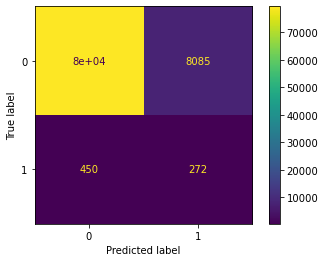

In [31]:
plot_confusion_matrix(tree_clf,X_test, y_test)

- simple tuning

In [34]:
std_slc = StandardScaler()
dec_tree = DecisionTreeClassifier()
pca = PCA()


pipe = Pipeline(steps=[('std_slc', std_slc), ('pca', pca), ('dec_tree', dec_tree)])

criterion = ['gini', 'entropy']
max_depth = np.arange(10,11,1)
min_samples_split = np.arange(7,10,1)
min_samples_leaf = np.arange(5,6,1)
pca_n_components = [0.8,0.9]

parameters = dict(dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth,
                  dec_tree__min_samples_split=min_samples_split,
                  dec_tree__min_samples_leaf=min_samples_leaf,
                  pca__n_components=pca_n_components)


tree_GS = GridSearchCV(pipe, parameters,scoring='recall')
tree_GS.fit(X_train_resampled, y_train_resampled)


In [ ]:
print('Best Criterion:', tree_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', tree_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best min_samples_split:', tree_GS.best_estimator_.get_params()['dec_tree__min_samples_split'])
print('Best min_samples_leaf:', tree_GS.best_estimator_.get_params()['dec_tree__min_samples_leaf'])

print(); 
print(tree_GS.best_estimator_.get_params()['dec_tree'])

In [ ]:
tree_2_best_model = tree_2_GS.best_estimator_
tree_2_best_model.fit(X_2_sub_train_resampled, y_2_sub_train_resampled)

plot_confusion_matrix(tree_2_best_model,X_2_sub_test, y_2_sub_test)
print(classification_report(y_2_sub_test, tree_2_best_model.predict(X_2_sub_test)))

In [7]:
tree_clf_raw = DecisionTreeClassifier(criterion = 'gini', random_state=2333)
tree_clf_raw.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2333)

In [8]:
tree_clf_raw.get_depth()

55

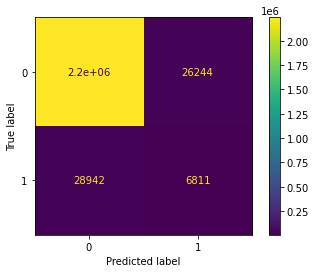

In [10]:
plot_confusion_matrix(tree_clf_raw,X_test, y_test)

In [12]:
print(classification_report(y_test, tree_clf_raw.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   2266903
           1       0.21      0.19      0.20     35753

    accuracy                           0.98   2302656
   macro avg       0.60      0.59      0.59   2302656
weighted avg       0.98      0.98      0.98   2302656



CONCLUSION:

- STOMP doesn't help that much for baseline model
- desicion tree works pretty fast (5 min)

# BALANCED RANDOM FOREST CLASSIFIER

In [8]:
# fit the BRFC model, will take about 90 min

BRFC_clf = BalancedRandomForestClassifier(random_state=2333)
BRFC_clf.fit(X_train_resampled, y_train_resampled) 

BalancedRandomForestClassifier(random_state=2333)

In [9]:
# save the model to disk
filename = 'Models/BRFC_baseline_model.pkl'
pickle.dump(BRFC_clf, open(filename, 'wb'))

In [14]:
# load the model
# about 40 seconds

file = open("Models/BRFC_baseline_model.pkl",'rb')
BRFC_clf_SMOTE = pickle.load(file)
file.close()

In [15]:
y_hat_test = BRFC_clf_SMOTE.predict(X_test)

print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99   2266903
           1       0.31      0.20      0.24     35753

    accuracy                           0.98   2302656
   macro avg       0.65      0.60      0.62   2302656
weighted avg       0.98      0.98      0.98   2302656



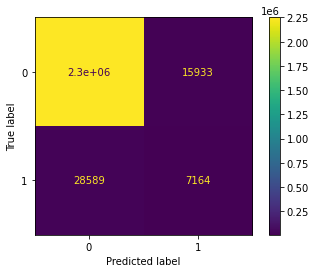

In [16]:
plot_confusion_matrix(BRFC_clf_SMOTE,X_test, y_test)

CONCLUSION:
- it took about 87 min to fit the BRFC & STOMP
- the results are not that great, a little bit better than desicion tree

# LOGISTIC REGRESSION

DON'T TRY!

In [23]:
df.head()

,label,age,gender,residence,city,city_rank,series_dev,series_group,emui_dev,device_name,...,creat_type_cd,adv_prim_id,inter_type_cd,slot_id,spread_app_id,hispace_app_tags,app_second_class,app_score,u_refreshTimes,u_feedLifeCycle
0,0,3,2,16,147,2,32,6,35,312,...,6,1846,4,46,162,47,14,10.0,0,15
1,1,3,2,16,147,2,32,6,35,312,...,8,1060,4,37,344,20,13,10.0,0,15
2,1,3,2,16,147,2,32,6,35,312,...,8,1060,4,37,344,20,13,10.0,0,15
3,0,3,2,16,147,2,32,6,35,312,...,8,1542,4,47,152,49,17,10.0,0,15
4,0,3,2,16,147,2,32,6,35,312,...,8,1036,4,44,312,43,18,10.0,0,15


In [32]:
df_logreg = df.drop(columns=['device_size','task_id','adv_id'])

In [33]:
col = df_logreg.columns
for c in col:
    print(c, len(df_logreg[c].unique()))

label 2
age 8
gender 3
residence 35
city 341
city_rank 4
series_dev 27
series_group 7
emui_dev 27
device_name 256
net_type 6
creat_type_cd 9
adv_prim_id 545
inter_type_cd 4
slot_id 60
spread_app_id 116
hispace_app_tags 43
app_second_class 20
app_score 3
u_refreshTimes 10
u_feedLifeCycle 8


In [34]:
df.device_size.sample(5)

2447798    2117
417767     2117
5589046    2438
3939055    2032
5628315    1684
Name: device_size, dtype: int64

In [38]:
logreg_baseline_pipe = Pipeline([
    ('OHE', OneHotEncoder(sparse = False, drop = 'first')), 
    ('model', LogisticRegression(random_state=2333))
    ])

logreg_baseline_pipe

Pipeline(steps=[('OHE', OneHotEncoder(drop='first', sparse=False)),
                ('model', LogisticRegression(random_state=2333))])

In [39]:
X_logreg = df_logreg.drop(columns='label')
y_logreg = df.label

X_train_logreg, X_test_logreg, y_train_logreg, y_test_logreg = train_test_split(X_logreg, y_logreg, test_size=0.3, random_state=2333)
X_train_logreg.shape, y_train_logreg.shape

((5372861, 20), (5372861,))

In [40]:
logreg_baseline_pipe.fit(X_train_logreg, y_train_logreg)

In [ ]:
# Previous original class distribution
print('Original class distribution: \n')
print(y_train_logreg.value_counts())
smote = SMOTE()
X_train_logreg_resampled, y_train_logreg_resampled = smote.fit_resample(X_train_logreg, y_train_logreg) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_logreg_resampled).value_counts()) 

## (TEST LOAD PICKLE)

In [19]:
file = open("Models/tree_baseline_model.pkl",'rb')
tree_clf = pickle.load(file)
file.close()

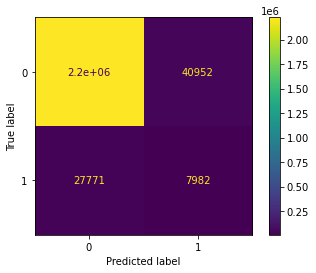

In [20]:
plot_confusion_matrix(tree_clf,X_test, y_test)